## Xception модели разпознавания deepfakes

In [3]:
#!c1.4
import os
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    MaxPool2D,
)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from PIL import Image, ImageChops, ImageEnhance
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import matplotlib.pyplot as plt

from data_prepare.dataset_tools import extract_zip_with_cleanup, prepare_and_save_data, create_data_generators
from data_prepare.plots import plot_history, confusion_matrix_plot, roc_plot, precision_recall_plot

In [11]:
def init_data():
    image_archive_path = "data/celeb/v1/"
    fake_images_path, real_images_path = extract_zip_with_cleanup(image_archive_path)
    train_dir, val_dir, test_dir = prepare_and_save_data(real_images_path, fake_images_path, output_dir="data/dataset/x")
    return create_data_generators(train_dir, val_dir, test_dir)

In [27]:
models_dir = "models"

### 1. Model fitting

In [23]:
def build_xception_model(input_shape=(299, 299, 3), num_classes=1):
    """
    Строит модель на основе Xception для обнаружения дипфейков

    Параметры:
        input_shape: размер входного изображения (по умолчанию 299x299 для Xception)
        num_classes: 1 для бинарной классификации (sigmoid), 2 для softmax
    """

    base_model = Xception(
        weights="imagenet", include_top=False, input_shape=input_shape
    )

    base_model.trainable = False

    model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            BatchNormalization(),
            Dense(256, activation="relu"),
            Dropout(0.5),
            Dense(num_classes, activation="sigmoid" if num_classes == 1 else "softmax"),
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy" if num_classes == 1 else "categorical_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )

    return model, base_model

In [22]:
def train_model(train_generator, val_generator):
    """
    Обучает модель на данных, загруженных в память

    Parameters:
        train_generator (np.array): Тренировочные изображения
        val_generator (np.array): Тестовые изображения

    Returns:
        tuple: (model, history) - обученная модель и история обучения
    """
    model, _ = build_xception_model()

    history = model.fit(
        train_generator,
        batch_size=32,
        epochs=10,
        validation_data=val_generator,
        callbacks=[
            ModelCheckpoint("best_model.h5", monitor="val_pr_auc", save_best_only=True),
            EarlyStopping(monitor="val_loss", patience=3),
        ],
    )

    return model, history

#### Подготовка данных и выполнение

In [12]:
train_gen, val_gen, test_gen = init_data()

Found 9074 images belonging to 2 classes.
Found 1944 images belonging to 2 classes.
Found 1946 images belonging to 2 classes.

Class indices: {'fake': 0, 'real': 1}
Train samples: 9074
Val samples: 1944
Test samples: 1946


In [ ]:
trained_model, histories = train_model(train_gen, val_gen)

2025-04-28 19:35:28.471718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5
2025-04-28 19:35:31.451634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/10


2025-04-28 19:35:35.231181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2025-04-28 19:35:39.403835: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3f0457f340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-28 19:35:39.403881: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-04-28 19:35:39.580353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 19:35:40.935433: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


284/284 [==============================] - ETA: 0s - loss: 0.5545 - precision: 0.2627 - recall: 0.1773 - auc: 0.5748

2025-04-28 19:36:47.964834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


284/284 [==============================] - 93s 294ms/step - loss: 0.5545 - precision: 0.2627 - recall: 0.1773 - auc: 0.5748 - val_loss: 0.4415 - val_precision: 0.5692 - val_recall: 0.1160 - val_auc: 0.6197
Epoch 2/10
284/284 [==============================] - 70s 246ms/step - loss: 0.4780 - precision: 0.4226 - recall: 0.1961 - auc: 0.6394 - val_loss: 0.4393 - val_precision: 0.5614 - val_recall: 0.1003 - val_auc: 0.6227
Epoch 3/10
284/284 [==============================] - 70s 247ms/step - loss: 0.4537 - precision: 0.4783 - recall: 0.2216 - auc: 0.6616 - val_loss: 0.4282 - val_precision: 0.6444 - val_recall: 0.0909 - val_auc: 0.6603
Epoch 4/10
284/284 [==============================] - 71s 250ms/step - loss: 0.4332 - precision: 0.5204 - recall: 0.2398 - auc: 0.6887 - val_loss: 0.4321 - val_precision: 0.5200 - val_recall: 0.1223 - val_auc: 0.6573
Epoch 5/10
284/284 [==============================] - 71s 250ms/step - loss: 0.4178 - precision: 0.5225 - recall: 0.2263 - auc: 0.7074 - val_lo

In [10]:
trained_model.save("xception_deepfake_model.h5")

In [5]:
trained_model = tf.keras.models.load_model("xception_deepfake_model.h5")

2025-04-29 19:04:44.008857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
#!gt4.1
test_loss, test_precision, test_recall, test_auc = trained_model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_auc:.4f}")

NameError: name 'trained_model' is not defined

### 2. Fine tuned

In [30]:
def train_model_finetune(train_generator, val_generator, model, base_model, fine_tune=False, initial_epochs=10, fine_tune_epochs=10):
    """
    Двухэтапное обучение с возможностью дообучения
    
    Parameters:
        train_generator: генератор тренировочных данных
        val_generator: генератор валидационных данных
        fine_tune: выполнять ли дообучение
        initial_epochs: количество эпох начального обучения
        fine_tune_epochs: количество эпох дообучения
    """
    
    history = model.fit(
        train_generator,
        epochs=initial_epochs,
        validation_data=val_generator,
        callbacks=[
            ModelCheckpoint(os.path.join(models_dir, "initial_model.h5"), monitor="val_auc", save_best_only=True, mode="max"),
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        ]
    )
    
    if not fine_tune:
        return model, history
    
    base_model.trainable = True
    
    for layer in base_model.layers[:int(len(base_model.layers)*0.7)]:
        layer.trainable = False
    
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ]
    )
    
    fine_tune_history = model.fit(
        train_generator,
        epochs=initial_epochs + fine_tune_epochs,
        initial_epoch=history.epoch[-1] + 1,
        validation_data=val_generator,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        ]
    )
    
    # Объединяем истории обучения
    full_history = {
        k: history.history[k] + fine_tune_history.history[k]
        for k in history.history
    }
    
    return model, full_history

#### Подготовка данных и выполнение

In [13]:
train_gen, val_gen, test_gen = init_data()

Found 9074 images belonging to 2 classes.
Found 1944 images belonging to 2 classes.
Found 1946 images belonging to 2 classes.

Class indices: {'fake': 0, 'real': 1}
Train samples: 9074
Val samples: 1944
Test samples: 1946


In [31]:
model, base_model = build_xception_model()
finetune_trained_model, finetune_histories = train_model_finetune(train_gen, val_gen, model, base_model, fine_tune=True, initial_epochs=5, fine_tune_epochs=10)

Epoch 1/5


/Users/aleksandr/opt/anaconda3/envs/deepfakedetection/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  5/284 ━━━━━━━━━━━━━━━━━━━━ 3:33 766ms/step - auc: 0.5207 - loss: 0.8084 - precision: 0.1316 - recall: 0.3778

KeyboardInterrupt: 

In [24]:
finetune_model_dir = os.path.join(models_dir, 'xception_finetune_deepfake_model.h5')
finetune_trained_model.save(finetune_model_dir)

NameError: name 'finetune_trained_model' is not defined

In [ ]:
finetune_history_df = pd.DataFrame(finetune_histories.history)
history_df.to_csv('results/x/finetune_training_history.csv', index=False)

In [ ]:
y_pred = finetune_trained_model.predict(test_gen)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.to_csv('results/x/y_pred.csv', index=False)

In [8]:
#!gt4.1
finetune_trained_model = tf.keras.models.load_model(finetune_model_dir)
test_loss, test_precision, test_recall, test_auc = finetune_trained_model.evaluate(test_gen)

print(f"\nTest AUC: {test_auc:.4f}, loss: {test_loss:.4f}, pression: {test_precision:.4f}, recall: {test_recall:4f}")

2025-05-02 09:55:15.198383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### Analyze results for finetuned model

In [13]:
y_pred = pd.read_csv('results/x/y_pred.csv')
y_true = test_gen.labels

In [14]:
finetune_loaded_history_df = pd.read_csv('results/x/finetune_training_history.csv')
finetune_loaded_history = {'history': finetune_loaded_history_df.to_dict()}

In [32]:
plot_history(finetune_loaded_history_df)

NameError: name 'finetune_loaded_history_df' is not defined

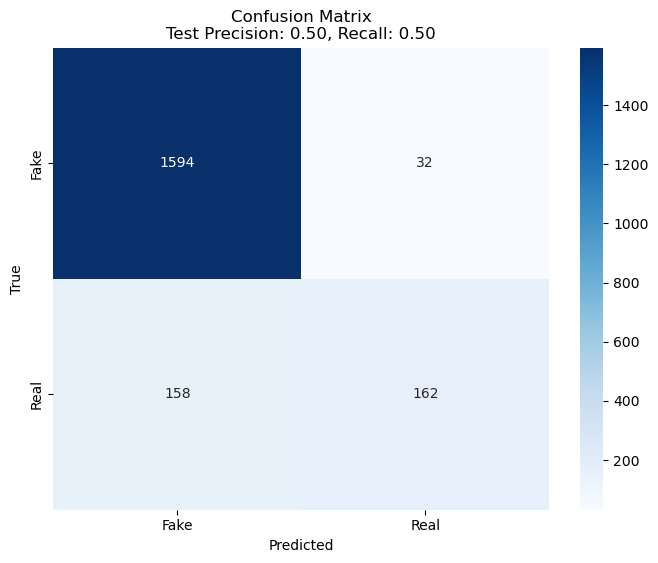

In [16]:
confusion_matrix_plot(y_pred, y_true, 0.5, 0.5)

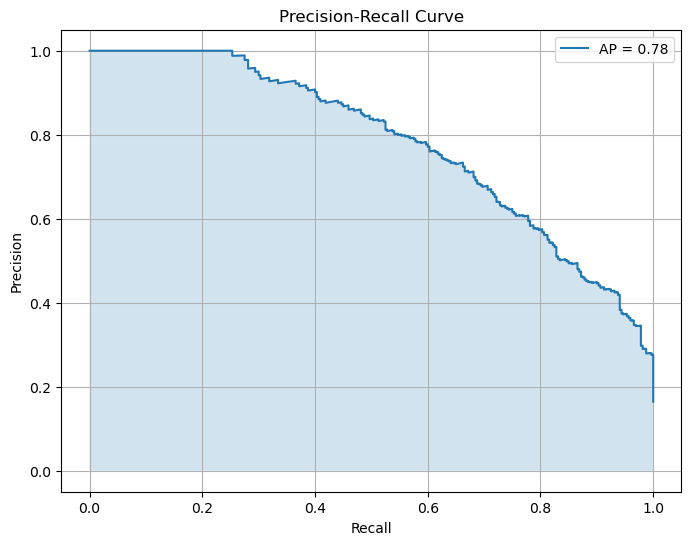

In [17]:
precision_recall_plot(y_true, y_pred)

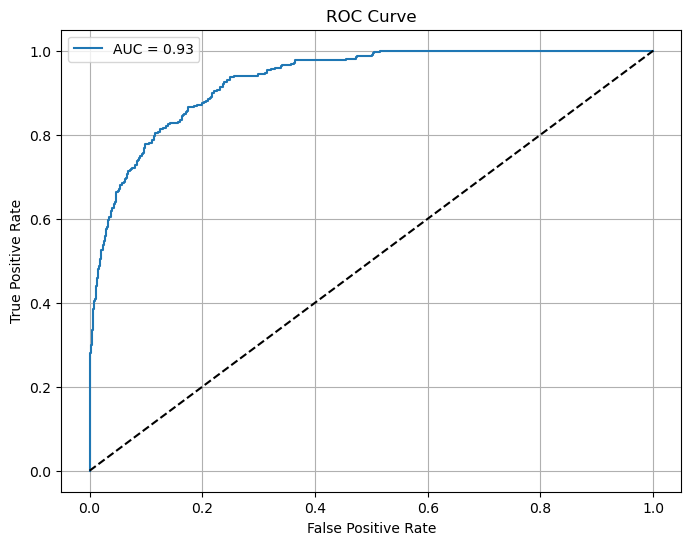

In [18]:
roc_plot(y_true, y_pred)

### 3. Pure model fitting

In [34]:
def build_pure_xception(input_shape=(299, 299, 3), num_classes=1):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ]
    )
    return model, base_model

In [15]:
train_gen, val_gen, test_gen = init_data()

Found 9074 images belonging to 2 classes.
Found 1944 images belonging to 2 classes.
Found 1946 images belonging to 2 classes.

Class indices: {'fake': 0, 'real': 1}
Train samples: 9074
Val samples: 1944
Test samples: 1946


In [37]:
model, base_model = build_pure_xception()
pure_finetuned_model, pure_finetuned_model_histories = train_model_finetune(train_gen, val_gen, model, base_model, fine_tune=True, initial_epochs=5, fine_tune_epochs=10)

Epoch 1/5
  1/284 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - auc: 0.6354 - loss: 0.5754 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
pure_finetuned_model_history_df = pd.DataFrame(pure_finetuned_model_histories.history)
pure_finetuned_model_history_df.to_csv('results/pure/pure_finetuned_history.csv', index=False)

In [ ]:
y_pred = finetune_trained_model.predict(test_gen)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.to_csv('results/pure/y_pred.csv', index=False)

#### Save results

In [ ]:
pure_finetune_model_dir = os.path.join(models_dir, 'xception_pure_finetuned_deepfake_model.h5')
pure_finetuned_model.save(pure_finetune_model_dir)

#### Analyze results for pure model